# Exercise 2

## Supervised Learning- Regression Models


---

## Overview

Welcome to this excercise. We are now going to use our new skills to build our supervised learning models that use an Elastict Net Regression.

---


In [ ]:
!pip install statsmodels

In [1]:
import sys
import os

# Manually set the path relative to the py file's location that you want to import
func_lib_path = os.path.abspath(os.path.join(os.getcwd(), '../../'))# Add the path to sys.path
sys.path.append(func_lib_path)

# Now you can import func_lib
import func_lib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet

In [2]:
# Retrieve historical price data.
# - Use the 'createHistPrices()' function from 'func_lib' to get historical price data.
# - Assign the result to the variable 'historical_prices'.

historical_prices = func_lib.create_hist_prices()

# Define the list of momentum periods.
# - Create a list containing different time periods for calculating momentum indicators.
# - Assign this list to the variable 'list_of_momentums'.

list_of_momentums = [1, 5, 15, 20]

# Compute returns based on historical prices and momentum periods.
# - Use the 'computingReturns()' function from 'func_lib' with 'historical_prices' and 'list_of_momentums' as inputs.
# - Assign the result to the variable 'total_returns'.

total_returns = func_lib.compute_returns(historical_prices, list_of_momentums)

# Remove any rows with missing values from the returns data.
# - Use the 'dropna()' method to remove rows with NaN values from 'total_returns'.
# - Apply the change in place to modify the DataFrame directly.

total_returns.dropna(inplace=True)


/workspace/CD13639-Project/func_lib.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sp500_tickers = pd.read_html(response.text)[0]['Symbol'].tolist()
[*********************100%***********************]  501 of 501 completed


In [3]:
# Determine the split index for 70% of the dates.
# - Extract the unique dates from the index of 'total_returns'.
# - Calculate the split date by indexing into the unique dates to get the date corresponding to 70% of the total length of unique dates.
# - Assign this date to the variable 'split_date' and display it.

unique_dates = total_returns.index.get_level_values('Date').unique()
split_date = unique_dates[int(0.7 * len(unique_dates))]
print(split_date)


2017-01-20 00:00:00


In [4]:
# Create the training set: all data before the split date.
# - Use the 'loc[]' indexer to select rows from 'total_returns' where the date in the index is earlier than 'split_date'.
# - Assign this subset of data to the variable 'train_data'.

train_data = total_returns.loc[total_returns.index.get_level_values('Date') < split_date]

# Create the testing set: all data from the split date onwards.
# - Use the 'loc[]' indexer to select rows from 'total_returns' where the date in the index is equal to or later than 'split_date'.
# - Assign this subset of data to the variable 'test_data'.

test_data = total_returns.loc[total_returns.index.get_level_values('Date') >= split_date]


In [5]:
# Extract the target variable for testing.
# - Select the 'F_1_d_returns' column from the 'test_data' DataFrame.
# - Assign this column to the variable 'total_returns'.

total_returns = test_data['F_1_d_returns']


In [6]:
# Define the feature and target columns.
# - List the names of the feature columns in 'features'.
# - List the name of the target column in 'target'.

features = ['1_d_returns', '5_d_returns', '15_d_returns', '20_d_returns']
target   = ['F_1_d_returns']

# Split the data into training and testing sets.
# - Extract the feature columns from 'train_data' and 'test_data' to create 'X_train' and 'X_test'.
# - Extract the target column from 'train_data' and 'test_data' to create 'y_train' and 'y_test'.

X_train = train_data[features]
X_test  = test_data[features]
y_train = train_data[target]
y_test  = test_data[target]


In [7]:
# Standardize the features.
# - Create an instance of 'StandardScaler' for scaling the features.
# - Fit the scaler to the training data and transform both the training and testing feature sets.
# - Convert the scaled arrays back to DataFrames with the same index and column names as the original feature sets.

scaler = StandardScaler()

# Scale the training features
X_train_scaled = scaler.fit_transform(X_train)
# Scale the testing features
X_test_scaled  = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)


In [8]:
# Initialize and fit an ElasticNet regression model.
# - Create an ElasticNet model instance with a specific alpha (regularization strength) and l1_ratio (mixing parameter between L1 and L2 regularization).
# - Fit the model to the scaled training data.

# Initialize ElasticNet with alpha and l1_ratio parameters
model = ElasticNet(alpha=0.001, l1_ratio=0.5)

# Fit the model to the training data
model.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.001)

In [9]:
# Set the model name.
# - Assign the name 'ElasticNet' to the variable 'model_name' to label the ElasticNet model.

model_name = 'ElasticNet'

# Make predictions using the fitted ElasticNet model.
# - Use 'model.predict()' to generate predictions based on the scaled testing features.

y_pred = model.predict(X_test_scaled)

# Create a DataFrame for the predicted values.
# - Convert the predicted values 'y_pred' to a DataFrame with the same index as the scaled testing features.
# - Rename the column in 'y_pred_df' to match the model name.

y_pred_df = pd.DataFrame(y_pred, index=X_test_scaled.index)
y_pred_df.rename(columns={0: model_name}, inplace=True)

# Create a DataFrame for the true target values.
# - Convert 'y_test' to a DataFrame.

y_test_df = pd.DataFrame(y_test)

# Combine the actual and predicted values into one DataFrame.
# - Use 'pd.merge()' to merge 'y_test_df' with 'y_pred_df' on their index.

y_test_and_pred = pd.merge(y_test_df, y_pred_df, left_index=True, right_index=True)


In [10]:
# Define a trading strategy based on logistic regression predictions.
# - Create a function 'trading_strategy' that takes the predicted value 'y_pred' as input.
# - If the predicted value is greater than 0, return 1 (indicating a "Go long" signal).
# - Otherwise, return 0 (indicating no action or "Do nothing").

def trading_strategy(y_pred):
    if y_pred > 0:
        return 1  # Go long
    else:
        return 0  # Do nothing


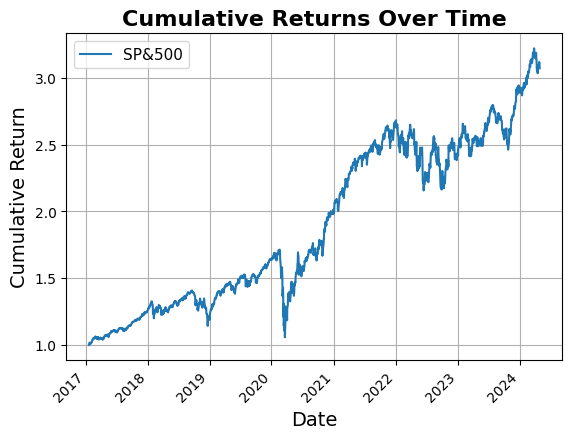

The CAGR is: 16.59%
Sharpe Ratio of Strategy: 0.88


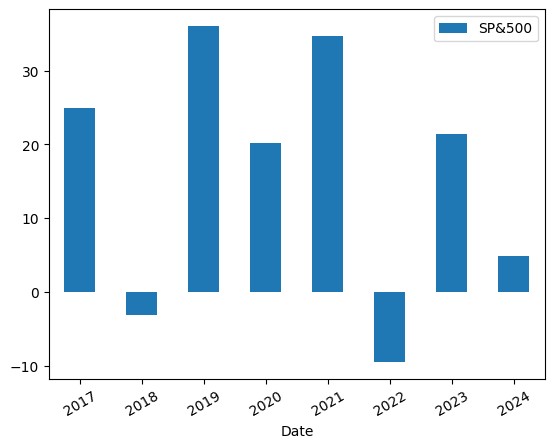

In [11]:
# Compute performance metrics based on the predictions and actual returns.
# - Use the 'func_lib.compute_BM_Perf()' function to calculate cumulative and calendar returns.
# - Pass the DataFrame 'y_test_and_pred' containing the actual and predicted values as an argument.

cum_returns, calendar_returns = func_lib.compute_BM_Perf(y_test_and_pred)


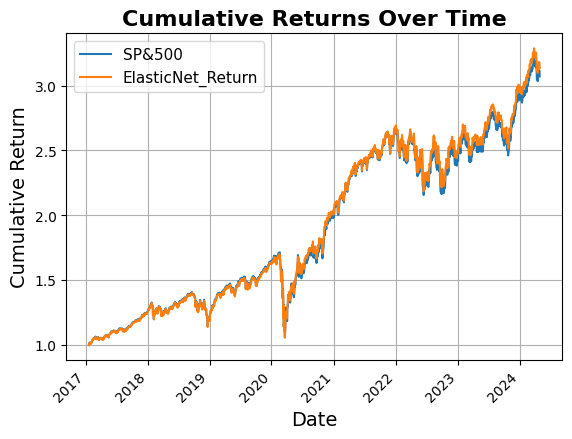

The CAGR is: 16.93%
Sharpe Ratio of Strategy: 0.92


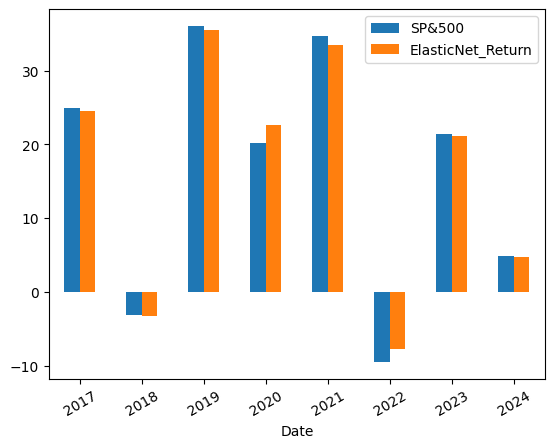

In [12]:
# Compute strategy performance metrics.
# - Use the 'func_lib.compute_strat_perf()' function to calculate the performance of the trading strategy.
# - Pass the following arguments:
#   - 'y_test_and_pred': The DataFrame containing actual and predicted values.
#   - 'cum_returns': Cumulative returns calculated previously.
#   - 'calendar_returns': Calendar returns calculated previously.
#   - 'trading_strategy': The function defining the trading strategy based on predictions.
#   - 'model_name': The name of the model to include in the performance evaluation.

cum_returns, calendar_returns = func_lib.compute_strat_perf(
    y_test_and_pred, 
    cum_returns, 
    calendar_returns, 
    trading_strategy, 
    model_name
)
